In [1]:
# 23122003 Nguyễn Văn Linh
# 23122022 Trần Hoàng Gia Bảo
# 23122026 Trần Chấn Hiệp
# 23122040 Nguyễn Thị Mỹ Kim

In [40]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import json

In [3]:

def standard_data(data: np.ndarray):
    mean = np.mean(data, axis=0)
    std = np.std(data, axis=0) + 1e-8 # Avoid division by zero
    return (data - mean) / std

def mean_squared_error(y, y_hat):
    n = len(y_hat)
    cost = np.sum(np.square(y_hat - y)) / n
    return cost

def mean_absolute_error(y, y_hat):
    n = len(y_hat)
    cost = np.sum(abs(y_hat - y)) / n
    return cost

def r2_score(y, y_hat):
    mean_y = np.mean(y)
    ss_total = np.sum((y - mean_y) ** 2)
    ss_residual = np.sum((y - y_hat) ** 2)
    r2 = 1 - (ss_residual / ss_total)
    return r2

def train_val_split(X, y, val_size=0.2, random_state=42):
    np.random.seed(random_state)
    n = len(X)
    inmodel_paramses = np.arange(n)
    np.random.shuffle(inmodel_paramses)
    val_idx = int(val_size * n)
    val_inmodel_paramses = inmodel_paramses[:val_idx]
    train_inmodel_paramses = inmodel_paramses[val_idx:]
    X_train, X_val = X.iloc[train_inmodel_paramses], X.iloc[val_inmodel_paramses]
    y_train, y_val = y.iloc[train_inmodel_paramses], y.iloc[val_inmodel_paramses]
    return X_train, X_val, y_train, y_val

def plot_xy(df, cols = 7, target_name="Price"):
    num_cols = df.shape[1] - 1 
    rows = (num_cols // cols) + (1 if num_cols % cols != 0 else 0) 

    fig, axes = plt.subplots(rows, cols, figsize=(25, 5 * rows)) 
    fig.subplots_adjust(hspace=0.5, wspace=0.25) 

    features = [col for col in df.columns if col != target_name]

    for i, col in enumerate(features):
        row, col_idx = divmod(i, cols) 
        ax = axes[row, col_idx] if rows > 1 else axes[col_idx] 
        ax.scatter(df[col], df[target_name], alpha=0.5, color='b')
        ax.set_xlabel(col, fontsize=12)
        ax.set_ylabel(target_name, fontsize=12)

    for i in range(len(features), rows * cols):  
        fig.delaxes(axes.flatten()[i])  

    plt.show()
    
def weak_corr(df, threshold = 0.3, target_name = "Price"):
    """
    Tính correlation của df với thuộc tính "Price", nếu corr yếu (corr < 0.3) thì return 
    """
    corr = df.corr()[target_name].drop(target_name)  
    
    excl = corr[abs(corr) < threshold].index.tolist()
    excl_model_paramst = {col: round(corr[col], 4) for col in corr.index if abs(corr[col]) < threshold}
    
    print(f"\nDropped features (correlation < {threshold}): {excl_model_paramst}")
    return excl

## READ DATA

In [4]:
df = pd.read_csv("train.csv")
df.head()

,Make,Model,Price,Year,Kilometer,Fuel Type,Transmission,Location,Color,Owner,Seller Type,Engine,Max Power,Max Torque,Drivetrain,Length,Width,Height,Seating Capacity,Fuel Tank Capacity
0,BMW,3-Series 320d,800000,2012,75576,Diesel,Automatic,Mumbai,White,Second,Individual,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,BMW,X1 sDrive20d xLine,2199000,2016,77000,Diesel,Automatic,Surat,Black,First,Individual,1995 cc,184 bhp @ 4000 rpm,350 Nm @ 1750 rpm,RWD,4454.0,2044.0,1545.0,5.0,63.0
2,Mahindra,XUV500 W4 1.99,800000,2017,112000,Diesel,Manual,Muzaffurpur,Silver,First,Individual,1997 cc,138 bhp @ 3750 rpm,320 Nm @ 1600 rpm,FWD,4585.0,1890.0,1785.0,7.0,70.0
3,Mercedes-Benz,GLS 400d 4MATIC,12900000,2021,3000,Diesel,Automatic,Delhi,White,First,Individual,2925 cc,326 bhp @ 3600 rpm,700 Nm @ 1200 rpm,AWD,5207.0,2157.0,1823.0,7.0,90.0
4,Toyota,Fortuner 2.8 4x2 AT [2016-2020],3499000,2019,73000,Diesel,Automatic,Mumbai,White,First,Individual,2755 cc,174 bhp @ 3400 rpm,450 Nm @ 1600 rpm,RWD,4795.0,1855.0,1835.0,7.0,80.0


# PREPROCESSING DATA

### TÁCH CÁC CỘT DỮ LIỆU CÓ (STRING + INT) 

Gồm: 'Engine', 'Max Power', 'Max Torque'

In [5]:
df["Engine"] = df["Engine"].str.extract(r'(\d+) cc').astype(float)

df[['max_power_bhp', 'max_power_rpm']] = df['Max Power'].str.extract(r'(\d+) bhp @ (\d+) rpm')
df['max_power_bhp'] = df['max_power_bhp'].map(lambda x: int(x) if pd.notna(x) else None)
df['max_power_rpm'] = df['max_power_rpm'].map(lambda x: int(x) if pd.notna(x) else None)

df[['max_torque_nm', 'max_torque_rpm']] = df["Max Torque"].str.extract(r'(\d+) Nm @ (\d+) rpm')
df['max_torque_nm'] = df['max_torque_nm'].map(lambda x: int(x) if pd.notna(x) else None)
df['max_torque_rpm'] = df['max_torque_rpm'].map(lambda x: int(x) if pd.notna(x) else None)

df.drop(["Max Power", "Max Torque"], axis='columns', inplace=True)

### XỬ LÝ CÁC DỮ LIỆU 'NAN'

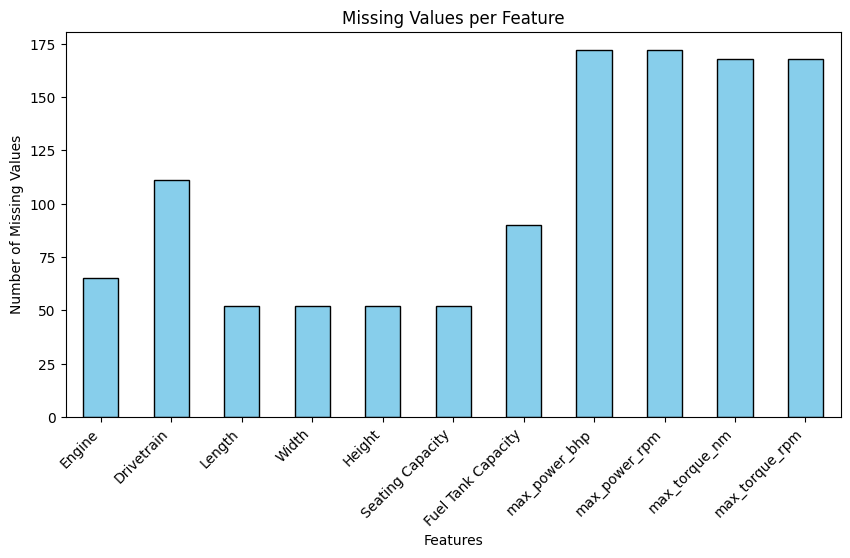

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

missing_values = df.isna().sum()

missing_values = missing_values[missing_values > 0]

plt.figure(figsize=(10, 5))
missing_values.plot(kind='bar', color='skyblue', edgecolor='black')

plt.xlabel("Features")
plt.ylabel("Number of Missing Values")
plt.title("Missing Values per Feature")
plt.xticks(rotation=45, ha="right")  

plt.show()


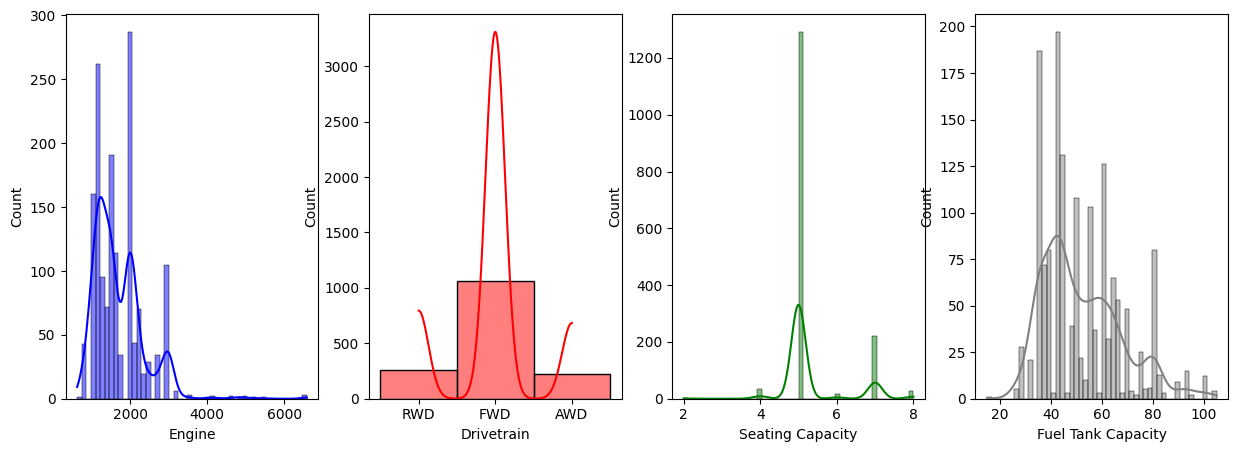

In [7]:
fig, axes = plt.subplots(1, 4, figsize=(15, 5))

sns.histplot(df['Engine'], bins=50, kde=True, color='blue', ax=axes[0])
sns.histplot(df['Drivetrain'], bins=50, kde=True, color='red', ax=axes[1])
sns.histplot(df['Seating Capacity'], bins=50, kde=True, color='green', ax=axes[2])
sns.histplot(df['Fuel Tank Capacity'], bins=50, kde=True, color='gray', ax=axes[3])
plt.show()

trong hình trên:

- cột engine lệch trái => dữ liệu skewed (không phân phối chuẩn) => điền khuyết 'nan' bằng giá trị median

- cột fwd là dữ liệu string => theo bảng, ta có thể chọn dữ liệu mode (xuất hiện nhiều nhất) để điền khuyết 'nan'

- cột seating capacity dữ liệu khá là rời rạc => chọn mode luôn

- fuel tank capacity => tùy vào góc nhìn có thể chọn median hoặc mean, ở đây chọn mean

In [8]:
# engine -> skewed
df['Engine'].fillna(df['Engine'].median(), inplace=True)

# Drive train chọn most frequent element
df["Drivetrain"].fillna(df["Drivetrain"].mode()[0], inplace=True)

# Capacity chọn most frequent element
df['Seating Capacity'].fillna(df['Seating Capacity'].mode()[0], inplace=True)

# fuel tank capacity chọn giá trị mean
df['Fuel Tank Capacity'].fillna(df['Fuel Tank Capacity'].mean(), inplace=True)

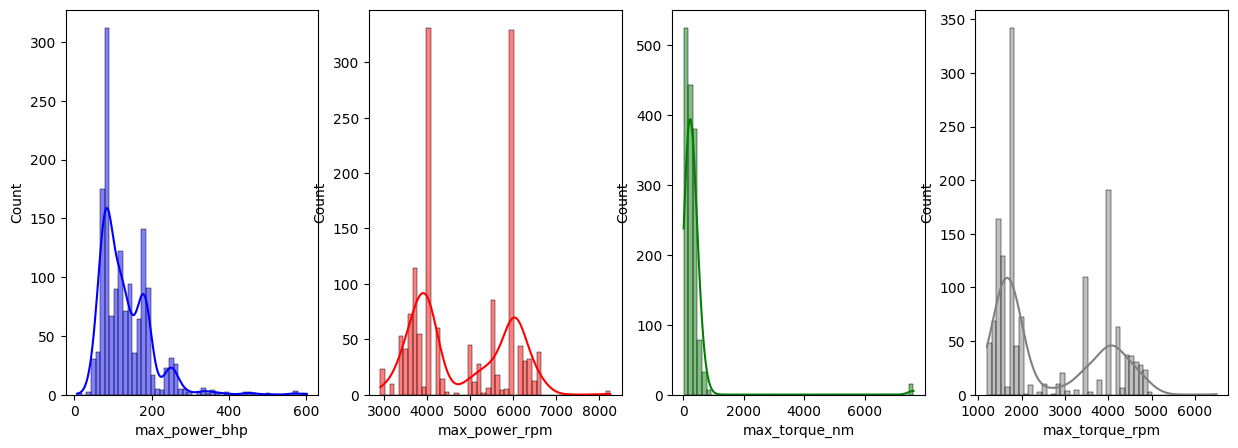

In [9]:
fig, axes = plt.subplots(1, 4, figsize=(15, 5))

sns.histplot(df['max_power_bhp'], bins=50, kde=True, color='blue', ax=axes[0])
sns.histplot(df['max_power_rpm'], bins=50, kde=True, color='red', ax=axes[1])
sns.histplot(df['max_torque_nm'], bins=50, kde=True, color='green', ax=axes[2])
sns.histplot(df['max_torque_rpm'], bins=50, kde=True, color='gray', ax=axes[3])
plt.show()

tương tự, trong hình trên:
- chọn mean để điền khuyết các cột 'max_power_bhp', 'max_power_rpm', 'max_torque_rpm'
- cột 'max_torque_nm' lệch trái (skewed) nên chọn median

In [10]:
df["max_power_bhp"].fillna(df["max_power_bhp"].mean(), inplace=True)
df["max_power_rpm"].fillna(df["max_power_rpm"].mean(), inplace=True)
df["max_torque_nm"].fillna(df["max_torque_nm"].median(), inplace=True)
df["max_torque_rpm"].fillna(df["max_torque_rpm"].mean(), inplace=True)

df.head()

,Make,Model,Price,Year,Kilometer,Fuel Type,Transmission,Location,Color,Owner,...,Drivetrain,Length,Width,Height,Seating Capacity,Fuel Tank Capacity,max_power_bhp,max_power_rpm,max_torque_nm,max_torque_rpm
0,BMW,3-Series 320d,800000,2012,75576,Diesel,Automatic,Mumbai,White,Second,...,FWD,NaN,NaN,NaN,5.0,52.154656,131.232542,4801.317966,220.0,2596.08384
1,BMW,X1 sDrive20d xLine,2199000,2016,77000,Diesel,Automatic,Surat,Black,First,...,RWD,4454.0,2044.0,1545.0,5.0,63.000000,184.000000,4000.000000,350.0,1750.00000
2,Mahindra,XUV500 W4 1.99,800000,2017,112000,Diesel,Manual,Muzaffurpur,Silver,First,...,FWD,4585.0,1890.0,1785.0,7.0,70.000000,138.000000,3750.000000,320.0,1600.00000
3,Mercedes-Benz,GLS 400d 4MATIC,12900000,2021,3000,Diesel,Automatic,Delhi,White,First,...,AWD,5207.0,2157.0,1823.0,7.0,90.000000,326.000000,3600.000000,700.0,1200.00000
4,Toyota,Fortuner 2.8 4x2 AT [2016-2020],3499000,2019,73000,Diesel,Automatic,Mumbai,White,First,...,RWD,4795.0,1855.0,1835.0,7.0,80.000000,174.000000,3400.000000,450.0,1600.00000


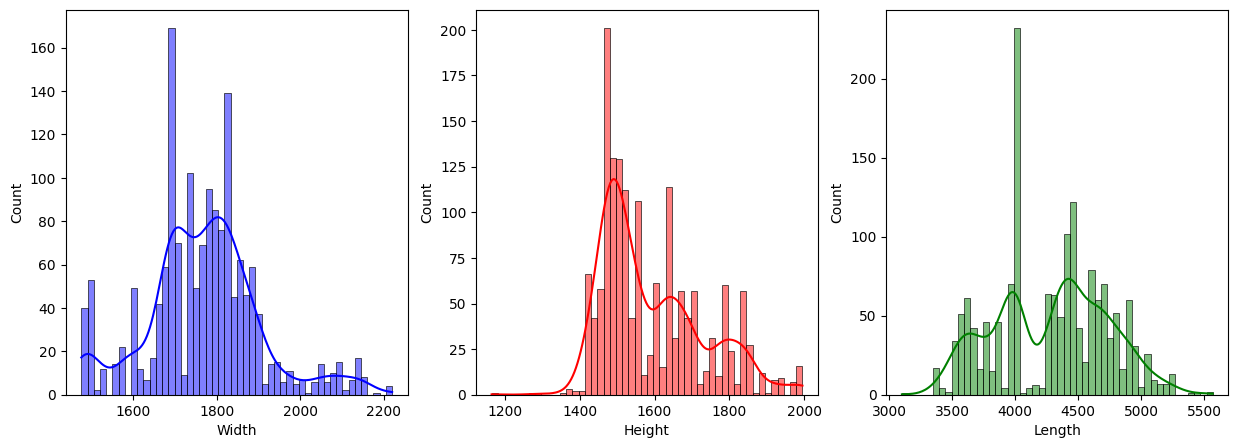

In [11]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

sns.histplot(df['Width'], bins=50, kde=True, color='blue', ax=axes[0])
sns.histplot(df['Height'], bins=50, kde=True, color='red', ax=axes[1])
sns.histplot(df['Length'], bins=50, kde=True, color='green', ax=axes[2])
plt.show()

In [12]:
df["Width"].fillna(df["Width"].mean(), inplace=True)
df["Height"].fillna(df["Height"].mean(), inplace=True)
df["Length"].fillna(df["Length"].mean(), inplace=True)

Kiểm tra liệu trong bảng có còn giá trị 'nan' nào nữa hay không

In [13]:
df.isna().any().any()

False

### XỬ LÝ DỮ LIỆU BỊ TRÙNG LẶP

In [14]:
# Tìm các hàng bị duplicate 
df[df.duplicated(keep=False)]

,Make,Model,Price,Year,Kilometer,Fuel Type,Transmission,Location,Color,Owner,...,Drivetrain,Length,Width,Height,Seating Capacity,Fuel Tank Capacity,max_power_bhp,max_power_rpm,max_torque_nm,max_torque_rpm


In [15]:
df.drop_duplicates(inplace=True)
df = df.reset_index(drop=True)

### XỬ LÝ CÁC DỮ LIỆU KIỂU OBJECT (chứa string)
in ra các giá trị unique trong các cột object

In [16]:
df_object = df.select_dtypes(["object"])
for col_name in df_object:
    print(len(df_object[col_name].unique()))
    print(col_name, ": ", df_object[col_name].unique())

31
Make :  ['BMW' 'Mahindra' 'Mercedes-Benz' 'Toyota' 'Maruti Suzuki' 'Land Rover'
 'Ford' 'Honda' 'Hyundai' 'Volvo' 'Tata' 'MG' 'Nissan' 'Audi' 'Renault'
 'Isuzu' 'Skoda' 'MINI' 'Jaguar' 'Mitsubishi' 'Kia' 'Datsun' 'Volkswagen'
 'Jeep' 'Porsche' 'Fiat' 'Ssangyong' 'Chevrolet' 'Lexus' 'Rolls-Royce'
 'Lamborghini']
912
Model :  ['3-Series 320d' 'X1 sDrive20d xLine' 'XUV500 W4 1.99' 'GLS 400d 4MATIC'
 'Fortuner 2.8 4x2 AT [2016-2020]'
 'Vitara Brezza ZDi+ Dual Tone [2017-2018]' 'DZire LDi'
 'E-Class E 220d Exclusive [2019-2019]' 'Range Rover 3.0 V6 Diesel Vogue'
 'Ecosport Titanium + 1.5L TDCi [2019-2020]'
 'City V CVT Petrol [2017-2019]' 'Creta 1.4 S' 'S60 Kinetic D4'
 'Vitara Brezza VDi' 'Safari 2.2 VX 4x2'
 'Hector Sharp 2.0 Diesel [2019-2020]'
 'Discovery Sport HSE Luxury 7-Seater' 'Terrano XL D Plus'
 '3-Series 330i M Sport Edition' 'Ertiga ZDI + SHVS'
 'GLC 220d 4MATIC Progressive' 'Verna 1.6 CRDI SX' 'Elantra 1.8 SX MT'
 'Q2 Premium 40 TFSI quattro' 'Q3 30 TDI Premium FWD' 'Alto L

Dữ liệu Model_encoded có 912 unique values trong khi tập train có 1647 mẫu dữ liệu, khi đó Model_encoded sẽ mô tả gần đúng với dữ liệu tập train. Correlation của log(Price) và Model_encoded là 0.96 (rất cao), mô hình học được chỉ cần nhìn vào Model_encoded (không cần các feature khác cũng có thể dự đoán mô hình).

(Vì sao sử dụng log(Price) được mô tả trong báo cáo)

Data leakage (rò rỉ dữ liệu) có thể xảy ra vì mô hình học từ tập train mà nó có thể sẽ không thể có trong quá trình dự đoán thực tế (Dòng xe mới chẳng hạn). Điều này khiến mô hình hoạt động rất tốt trên tập train/validation nhưng có thể không dự đoán được trên dữ liệu mới (test set).

Correlation model_encoded & log(price): 0.9636664381314428
Correlation model_encoded & log(price): 0.6752243381315025


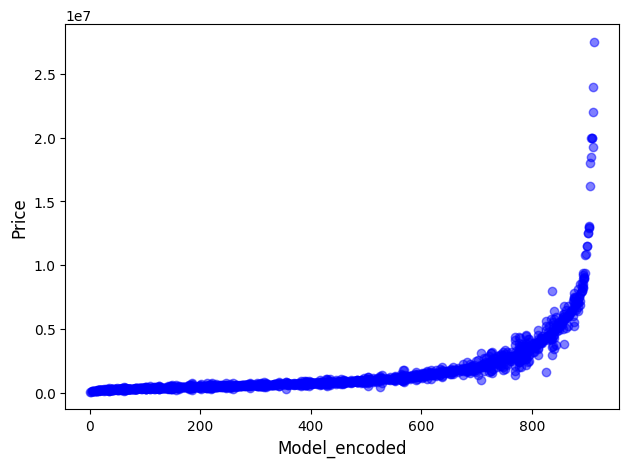

In [17]:
# sắp xếp model của các xe (model xe nào thường có giá trị trung bình cao hơn thì label model có giá trị lớn hơn)
model_price_mean = df.groupby('Model')['Price'].mean().sort_values()
model_mapping = {color: rank for rank, color in enumerate(model_price_mean.index, 1)}
df['Model_encoded'] = df['Model'].map(model_mapping)
df[['Model', 'Model_encoded']].drop_duplicates().sort_values(by='Model_encoded')
correlation = df['Model_encoded'].corr(np.log1p(df['Price']))
print("Correlation model_encoded & log(price):", correlation)
correlation = df['Model_encoded'].corr(df['Price'])
print("Correlation model_encoded & log(price):", correlation)
plot_xy(df[["Model_encoded", "Price"]], cols=3)

Nhóm lựa chọn loại bỏ Model_encoded

In [18]:
df.drop("Model_encoded", axis=1, inplace=True)

ordered categories (Owner) : ordinal encoding

In [19]:
model_params = {}

In [20]:
# Ordinal Encoding
owner_mapping = {
    'First': 1, 
    'Second': 2, 
    'Third': 3, 
    'Fourth': 4, 
    '4 or More': 5, 
    'UnRegistered Car': 0
}
df['Owner'] = df['Owner'].map(owner_mapping)
model_params["owner_mapping"] = owner_mapping

categorical variables with MANY unique values (Make, Color, Fuel Type) : target encoding 

In [21]:
# sắp xếp label của các hãng xe (hãng xe có giá trị trung bình (price) cao hơn thì label hãng xe có giá trị lớn hơn)
make_price_mean = df.groupby('Make')['Price'].mean().sort_values()
make_mapping = {make: rank for rank, make in enumerate(make_price_mean.index, 1)}
df['Make_encoded'] = df['Make'].map(make_mapping)
model_params["make_mapping"] = make_mapping
df[['Make', 'Make_encoded']].drop_duplicates().sort_values(by='Make_encoded')

,Make,Make_encoded
115,Datsun,1
372,Fiat,2
486,Chevrolet,3
32,Renault,4
17,Nissan,5
5,Maruti Suzuki,6
10,Honda,7
11,Hyundai,8
198,Volkswagen,9
475,Ssangyong,10


In [22]:
# sắp xếp location của các màu xe (location xe nào thường có giá trị trung bình cao hơn thì label location có giá trị lớn hơn)
location_price_mean = df.groupby('Location')['Price'].mean().sort_values()
location_mapping = {color: rank for rank, color in enumerate(location_price_mean.index, 1)}
df['Location_encoded'] = df['Location'].map(location_mapping)
model_params['location_mapping'] = location_mapping
df[['Location', 'Location_encoded']].drop_duplicates().sort_values(by='Location_encoded')

,Location,Location_encoded
1112,Unnao,1
1319,Siliguri,2
405,Faizabad,3
751,Deoghar,4
37,Jamshedpur,5
...,...,...
1,Surat,72
105,Chandigarh,73
17,Chennai,74
748,Vadodara,75


In [23]:
# sắp xếp label của các màu xe (màu xe nào thường có giá trị trung bình cao hơn thì label màu có giá trị lớn hơn)
color_price_mean = df.groupby('Color')['Price'].mean().sort_values()
color_mapping = {color: rank for rank, color in enumerate(color_price_mean.index, 1)}
df['Color_encoded'] = df['Color'].map(color_mapping)
model_params['color_mapping'] = color_mapping
df[['Color', 'Color_encoded']].drop_duplicates().sort_values(by='Color_encoded')

,Color,Color_encoded
1028,Pink,1
139,Others,2
25,Gold,3
2,Silver,4
36,Brown,5
134,Orange,6
11,Grey,7
158,Beige,8
37,Maroon,9
159,Green,10


In [24]:
# sắp xếp label của các fuel_type (fuel_type nào thường có giá trị trung bình cao hơn thì label fuel_type có giá trị lớn hơn)
fuel_price_mean = df.groupby('Fuel Type')['Price'].mean().sort_values()
fuel_mapping = {fuel: rank for rank, fuel in enumerate(fuel_price_mean.index, 1)}
df['Fuel_type_encoded'] = df['Fuel Type'].map(fuel_mapping)
model_params['fuel_mapping'] = fuel_mapping
df[['Fuel Type', 'Fuel_type_encoded']].drop_duplicates().sort_values(by='Fuel_type_encoded')

,Fuel Type,Fuel_type_encoded
1176,Petrol + LPG,1
38,LPG,2
350,CNG + CNG,3
35,CNG,4
10,Petrol,5
648,Electric,6
0,Diesel,7
1083,Hybrid,8


categorical variables with FEW unique values ('Transmission', 'Drivetrain', 'Seller Type') : one-hot encoding (avoids false ordinal relationships)

In [25]:
# one hot encoding
df = pd.get_dummies(df, columns=['Transmission', 'Drivetrain', 'Seller Type'], dtype=int)

In [26]:
# lưu các giá trị mapping vào 'model_params.json':
model_params["MODEL"] = {}
with open("model_params.json", "w") as f:
    json.dump(model_params, f, indent=4)

Loại bỏ các cột object (dữ liệu string)

In [27]:
df.drop(df.select_dtypes(["object"]), axis='columns', inplace=True)

### CHUẨN HÓA CÁC DỮ LIỆU SỐ

In [28]:
# Chuyển dữ liệu năm => tuổi của xe
# Công thức: df["Year"].max() - năm sản xuất của xe đó + 1
# ví dụ: df["Year"].max() = 2022, năm sản xuất là 2020, thì tuổi là 3
print(df["Year"].max())
df['Age'] = df["Year"].max() - df["Year"] + 1
df.drop(['Year'], axis='columns', inplace=True)

2022


In [29]:
df.head()

,Price,Kilometer,Owner,Engine,Length,Width,Height,Seating Capacity,Fuel Tank Capacity,max_power_bhp,...,Fuel_type_encoded,Transmission_Automatic,Transmission_Manual,Drivetrain_AWD,Drivetrain_FWD,Drivetrain_RWD,Seller Type_Commercial Registration,Seller Type_Corporate,Seller Type_Individual,Age
0,800000,75576,2,1498.0,4281.47837,1767.580564,1592.423824,5.0,52.154656,131.232542,...,7,1,0,0,1,0,0,0,1,11
1,2199000,77000,1,1995.0,4454.00000,2044.000000,1545.000000,5.0,63.000000,184.000000,...,7,1,0,0,0,1,0,0,1,7
2,800000,112000,1,1997.0,4585.00000,1890.000000,1785.000000,7.0,70.000000,138.000000,...,7,0,1,0,1,0,0,0,1,6
3,12900000,3000,1,2925.0,5207.00000,2157.000000,1823.000000,7.0,90.000000,326.000000,...,7,1,0,1,0,0,0,0,1,2
4,3499000,73000,1,2755.0,4795.00000,1855.000000,1835.000000,7.0,80.000000,174.000000,...,7,1,0,0,0,1,0,0,1,4


## LINEAR REGRESSION

Có $n$ samples, mỗi sample có $m$ features
$$
\hat{Y} = XW + b 
$$
$$
X \in \mathbb{R}^{n \times m}, W \in \mathbb{R}^{m}, \hat{Y} \in \mathbb{R}^{n}
$$
Loss Function (Mean Squared Error):
$$
J(W, b) = \frac{1}{N} \sum_{1}^{n}(\hat{y_i} - y_i)^2 = \frac{1}{N} \sum_{1}^{n}(x_iW + b - y_i)^2
$$
Đạo hàm theo $w$ của Loss Fuction:
$$
\nabla _W J = \frac{\partial J}{\partial W} = \frac{2}{N} X^T (XW + b - Y)
$$

Đạo hàm theo $b$ của Loss Fuction:
$$
\nabla _b J = \frac{\partial J}{\partial b} = \frac{2}{N} \sum_{1}^{n}(x_iW + b - y_i)
$$

Công thức cập nhật $W$ tại lần t:
$$
W_t = W_{t - 1} - \eta \nabla _W J
$$

Công thức cập nhật $b$ tại lần t:
$$
b_t = b_{t - 1} - \eta \nabla _b J
$$

In [30]:
class LinearRegression:
    def __init__(self, learning_rate=0.01, epsilon=1e-6):
        self.learning_rate = learning_rate
        self.epsilon = epsilon
        self.W = None
        self.b = None
    
    def _init_params(self, n_features):
        self.W = np.random.randn(n_features) * 0.01
        self.b = 0
    
    def forward(self, X):
        return np.dot(X, self.W) + self.b

    def backward(self, y_hat):
        n = len(y_hat)
        self.dW = 2 * np.dot(self.X.T, (y_hat - self.y)) / n  
        self.db = 2 * np.mean(y_hat - self.y) 
    
    def fit(self, X, y, epochs):
        self.X = X
        self.y = y
        self._init_params(X.shape[1])
        costs = []
        
        for ep in range(1, epochs + 1):
            y_hat = self.forward(X)
            cost = mean_squared_error(y=self.y, y_hat=y_hat)
            self.backward(y_hat)
            self.W = self.W - self.learning_rate * self.dW
            self.b = self.b - self.learning_rate * self.db
            costs.append(cost)
            
            if ep > 1 and abs(costs[-1] - costs[-2]) <= self.epsilon: 
                print(f"Converged after {ep} epochs")
                break
            
    def predict(self, X):
        return self.forward(X)
    
    def true_y(self, y):
        return np.expm1(y)
    
    def save_model(self, name_model):
        with open("model_params.json", "r") as f:
            params = json.load(f)
        
        models_dict = params["MODEL"]

        models_dict[name_model] = {
            "W": [f"{w:.64f}" for w in self.W.tolist()],
            "b": f"{self.b:.64f}",
            "features": self.X.columns.tolist(),
        }

        with open("model_params.json", "w") as f:
            json.dump(params, f, indent=4)



## DƯỚI ĐÂY LÀ ẢNH VẼ CÁC FEATURES VỚI TARGET "PRICE" (*)

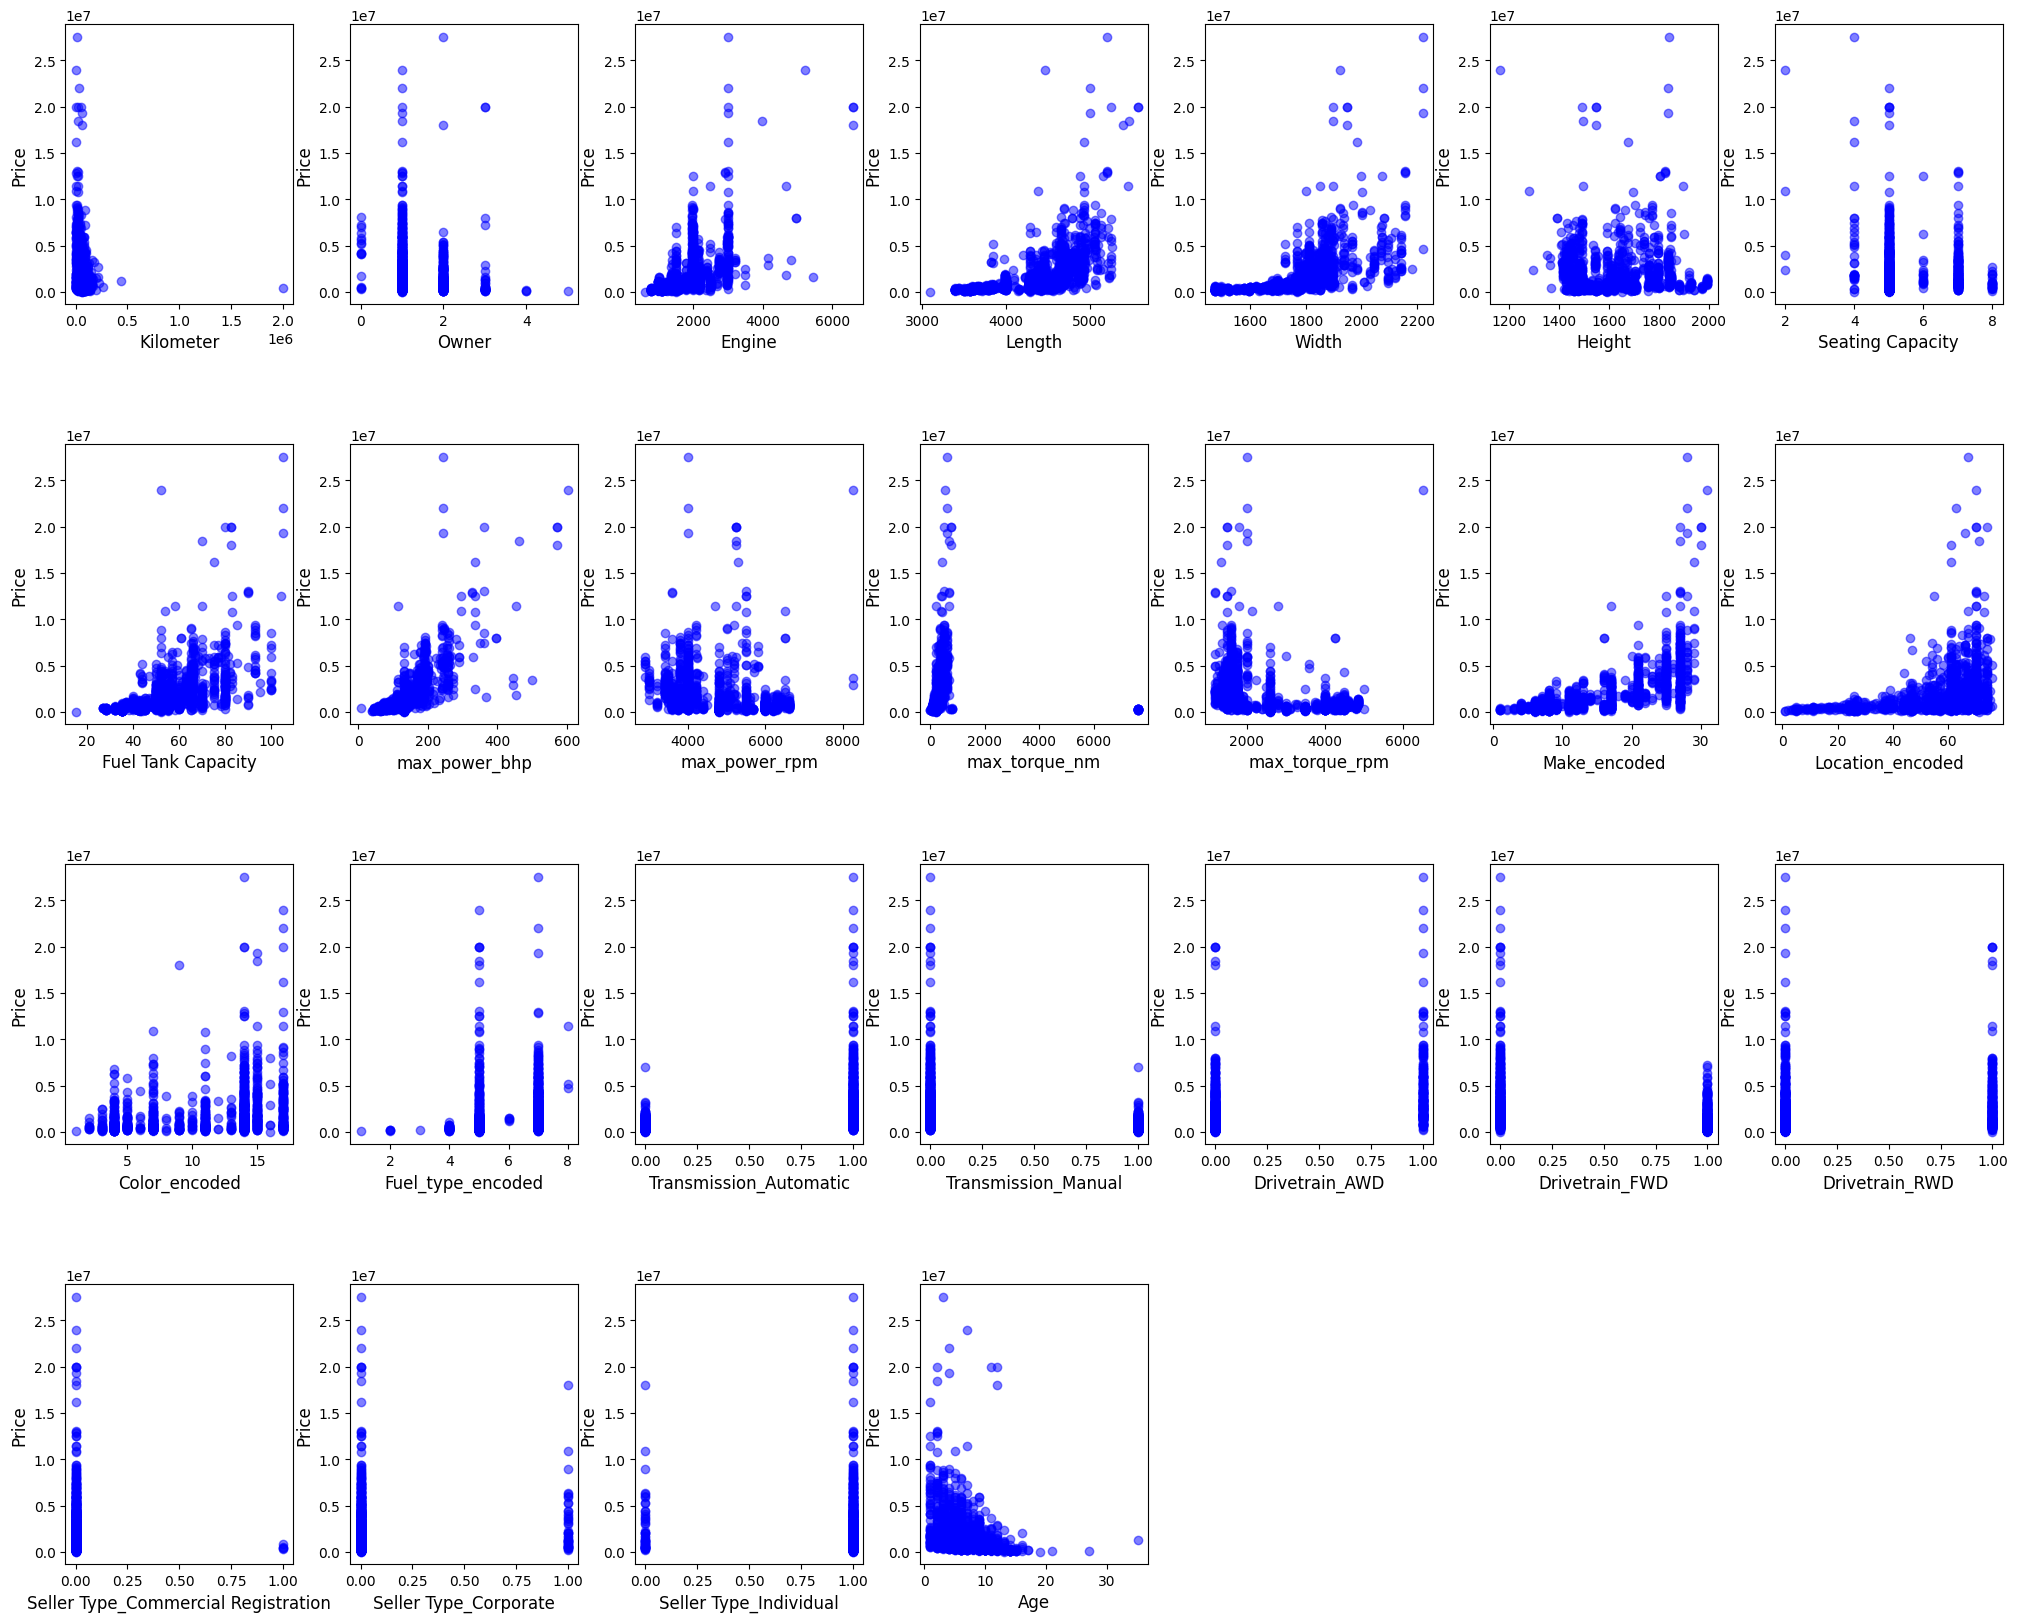

In [31]:
plot_xy(df)

## DƯỚI ĐÂY LÀ MA TRẬN CORRELATION CỦA DATASET

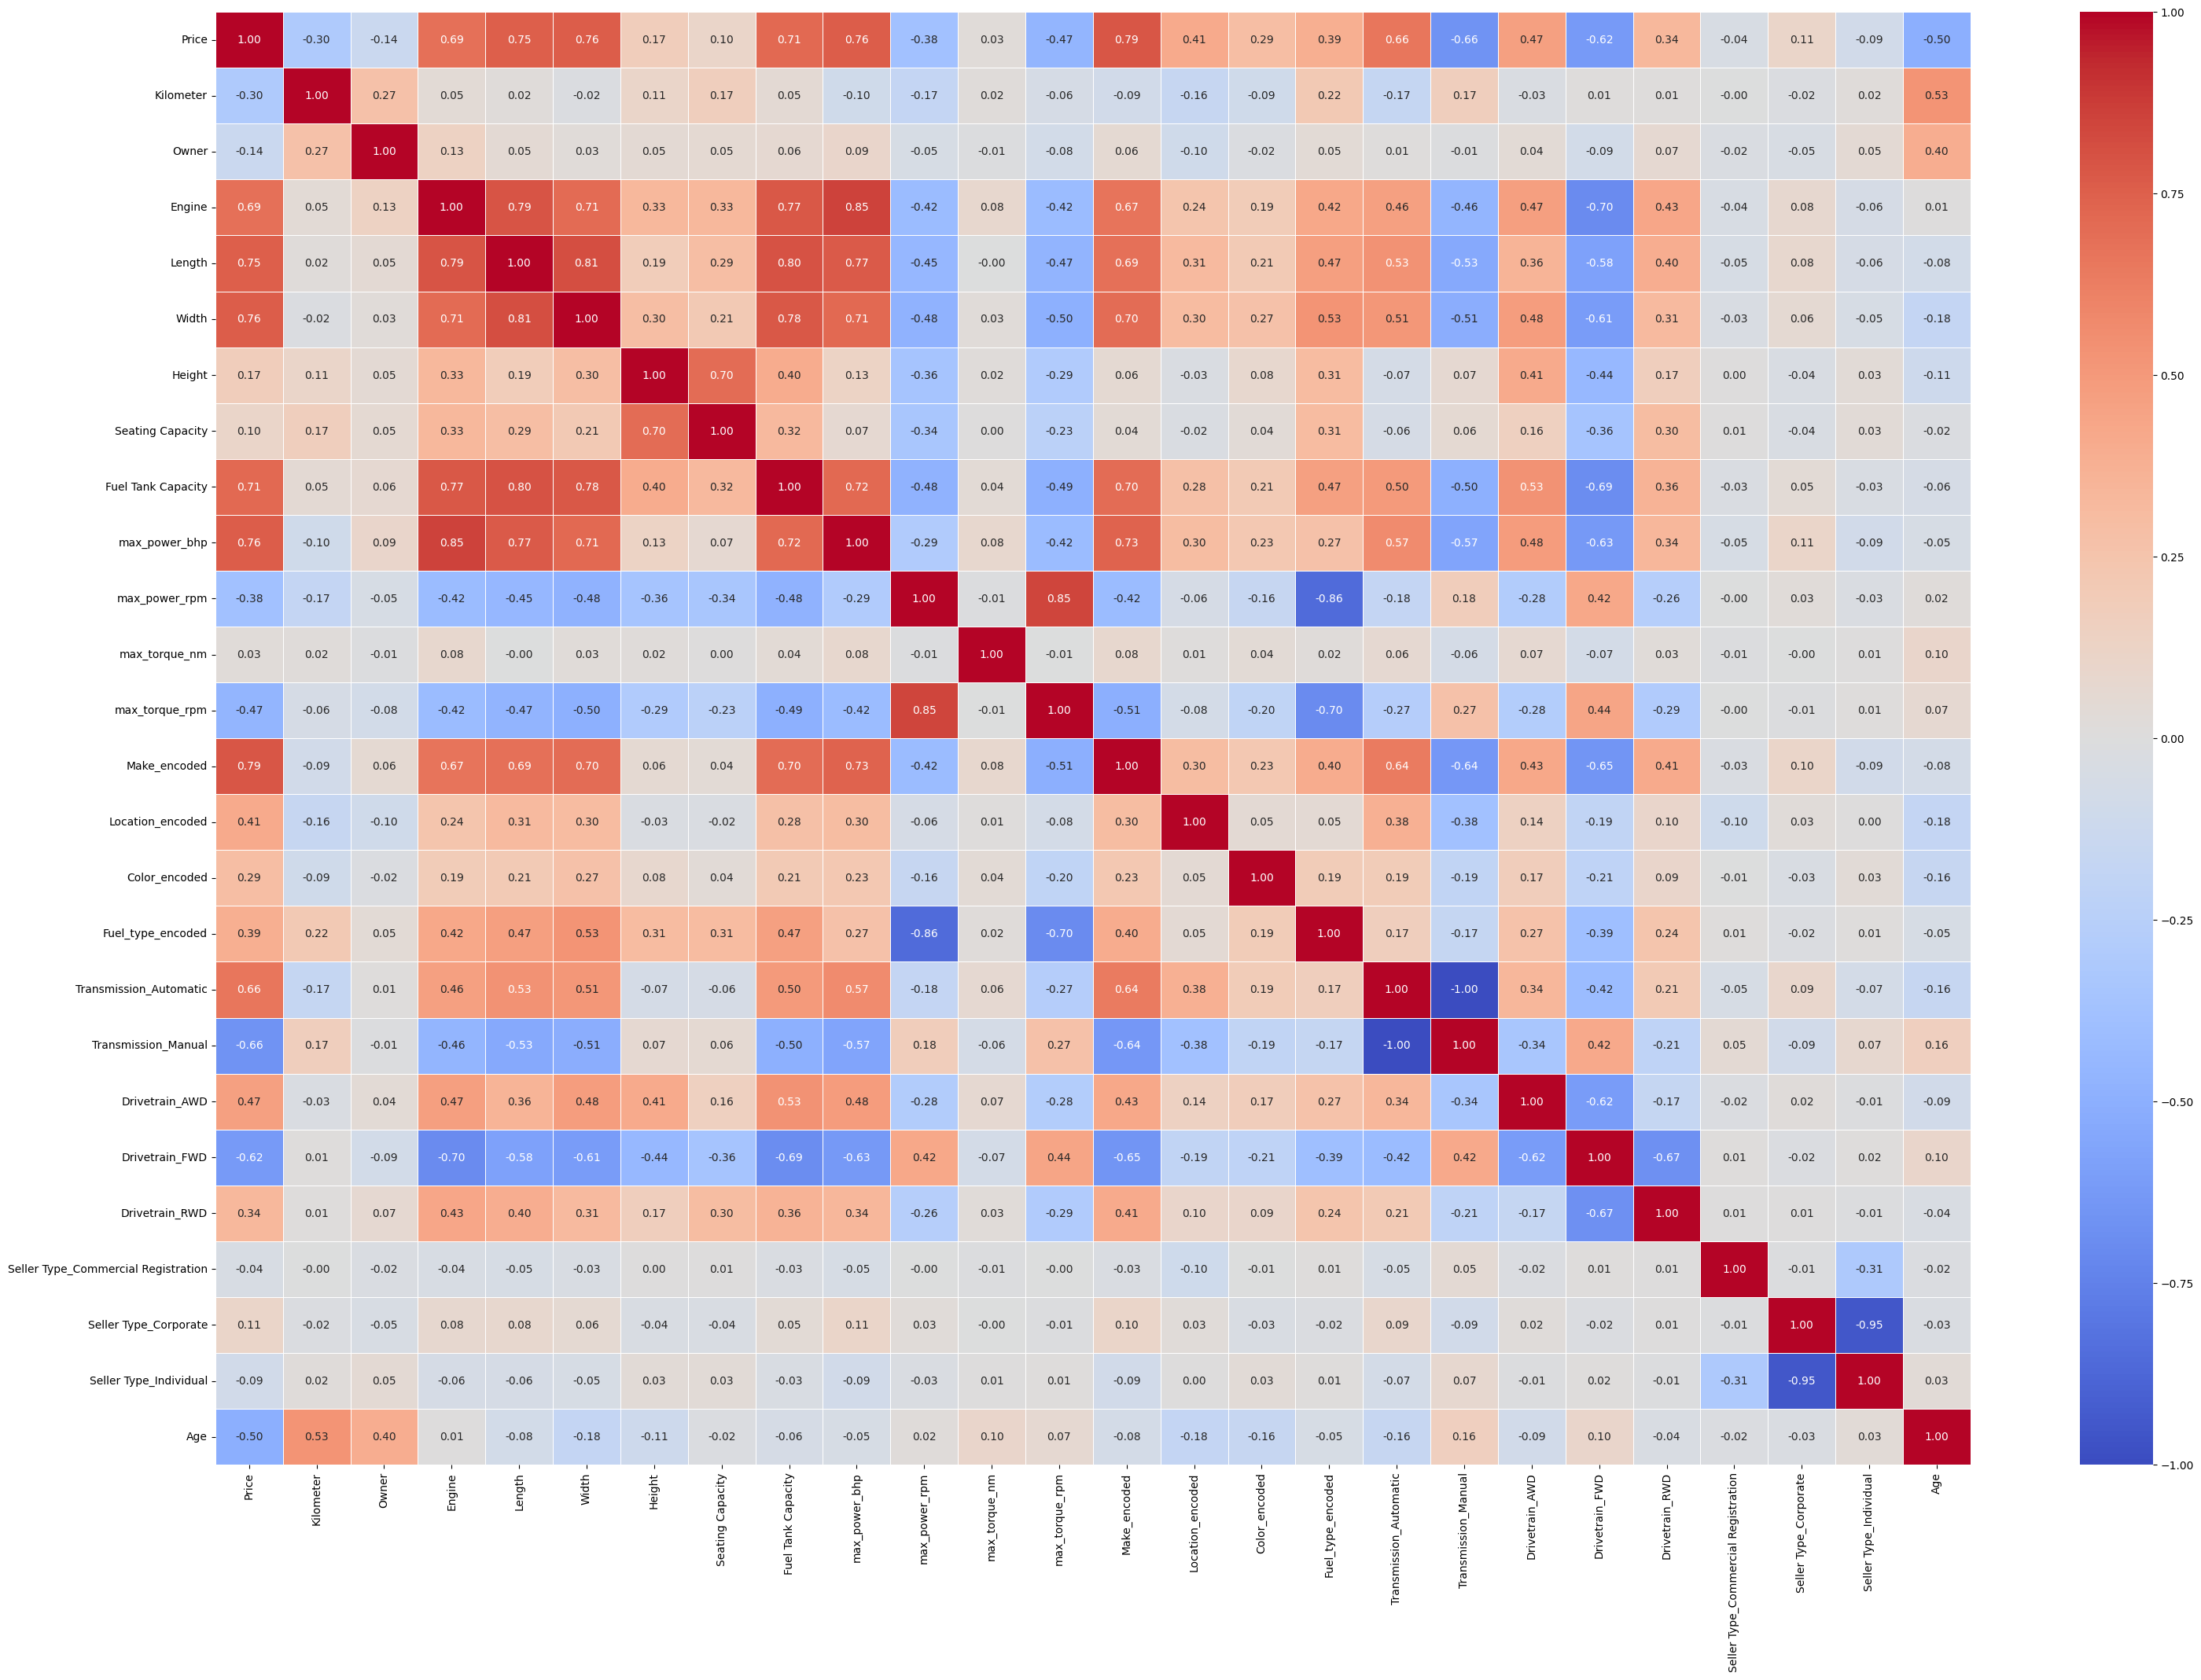

In [32]:
df1 = df.copy()
df1['Price'] = np.log1p(df1['Price']) 
df1['Kilometer'] = np.log1p(df1['Kilometer'])
corr_matrix = df1.corr()
plt.figure(figsize=(36, 24))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.show()

## MODEL 1
Nhìn vào ảnh vẽ (*), ta có thể sử dụng:

- Các đường dữ liệu đều có xu hướng đi kiểu $y = ae^{bx + c}$ => làm các đường dữ liệu có vẻ thẳng (tuyến tính hơn) ta có thể biến đổi log (log-transforming) cho $y$ (Price)
$$log(\^y) = XW + b$$
- Sau khi biến đổi log cho Price, ta thấy đa số các thuộc tính theo Price_log khá tuyến tính.


Dropped features (correlation < 0.3): {'Kilometer': -0.1572, 'Owner': -0.1351, 'Height': 0.1723, 'Seating Capacity': 0.1046, 'max_torque_nm': 0.0291, 'Color_encoded': 0.2934, 'Seller Type_Commercial Registration': -0.0391, 'Seller Type_Corporate': 0.1075, 'Seller Type_Individual': -0.09}


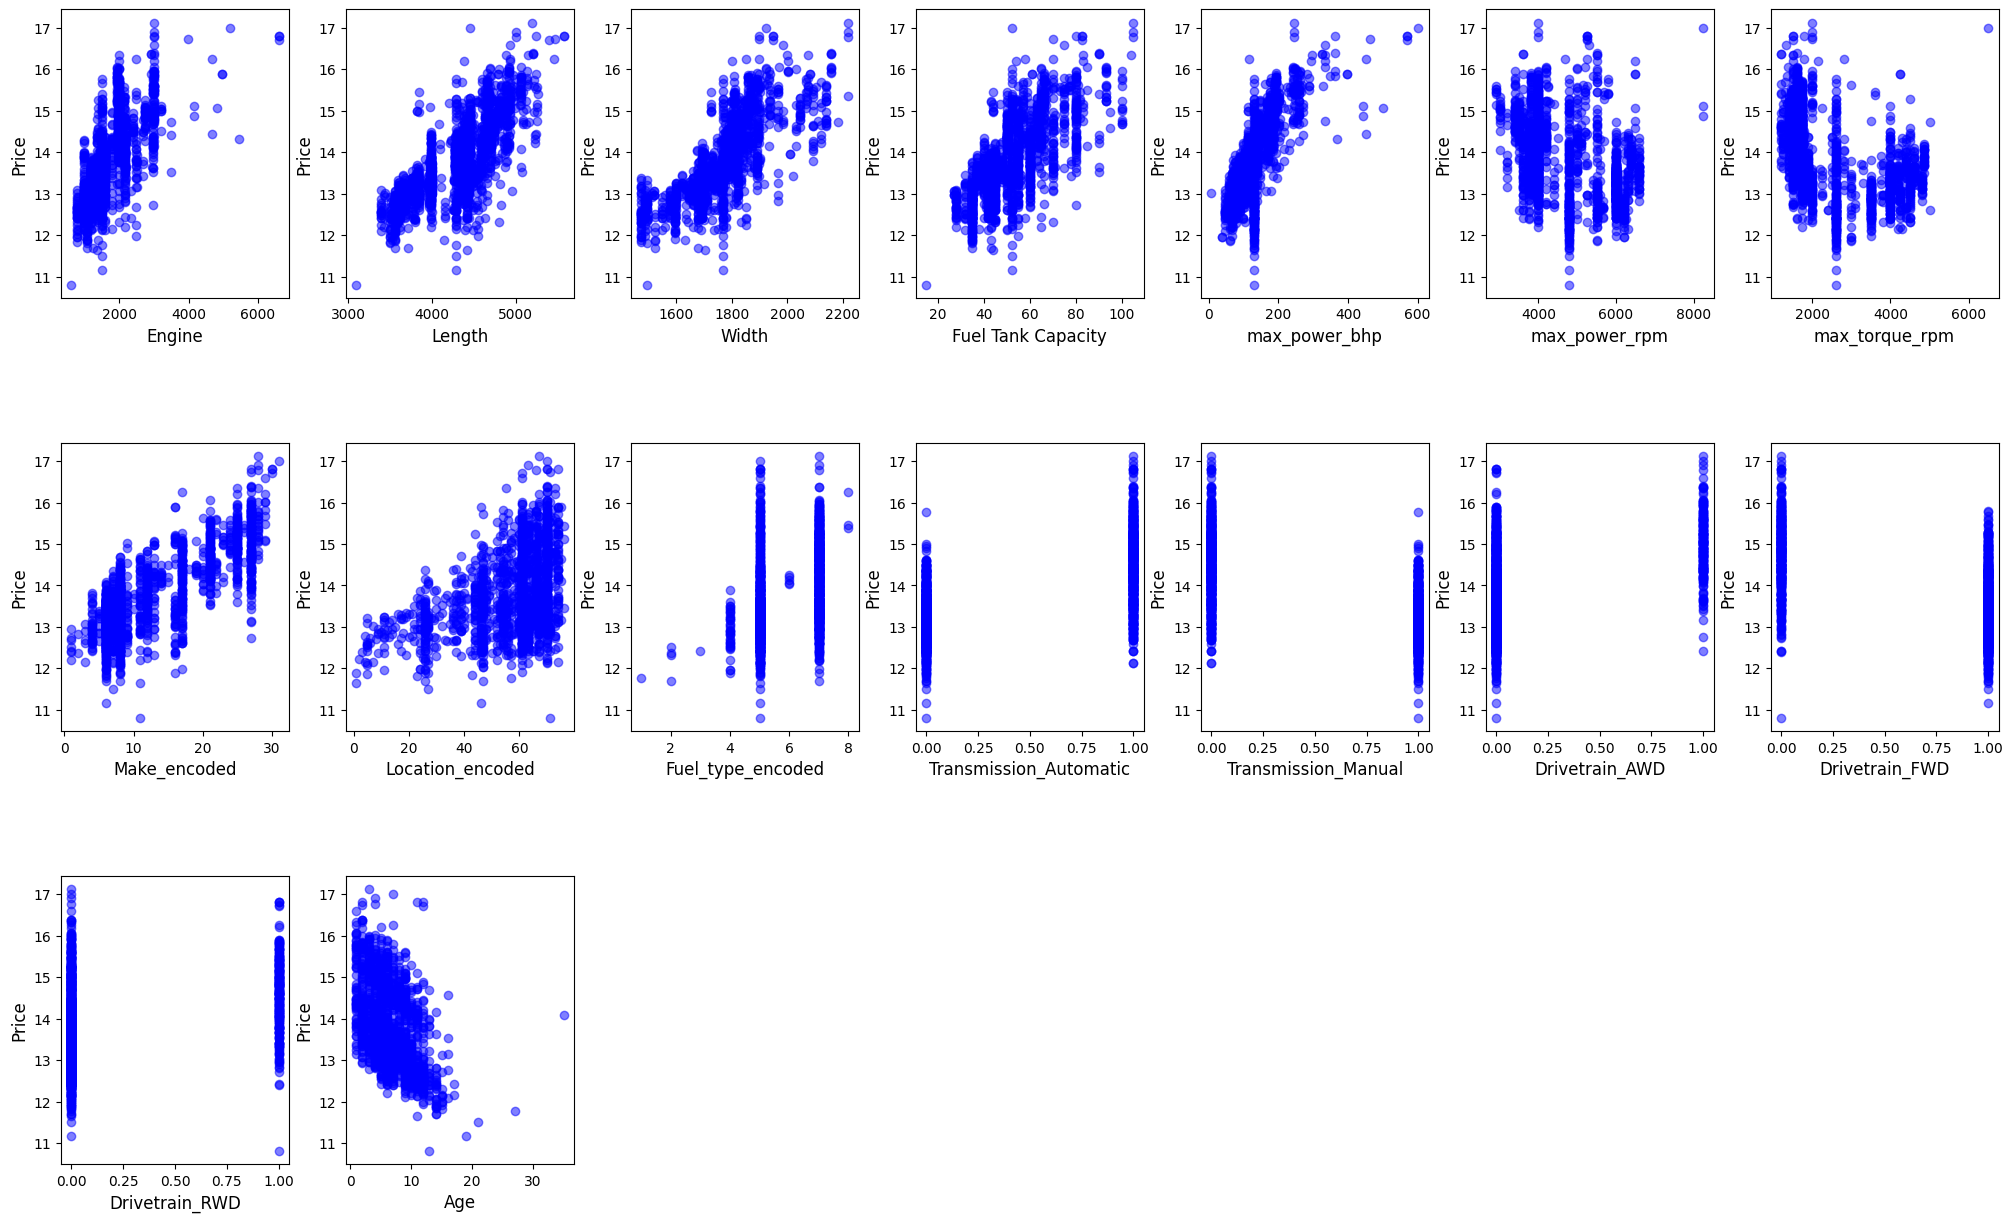

Y = log(Price) và các đặc trưng được chọn:  ['Engine', 'Length', 'Width', 'Fuel Tank Capacity', 'max_power_bhp', 'max_power_rpm', 'max_torque_rpm', 'Make_encoded', 'Location_encoded', 'Fuel_type_encoded', 'Transmission_Automatic', 'Transmission_Manual', 'Drivetrain_AWD', 'Drivetrain_FWD', 'Drivetrain_RWD', 'Age']
Converged after 612 epochs
Train Mean Squared Error: 0.07585164127107055
Train Mean Absolute Error: 0.19561999461632756
Train R² Score: 0.9245510959790402
Val Mean Squared Error: 0.07585164127107055
Val Mean Absolute Error: 0.18520868149619768
Val R² Score: 0.9331600740041868


In [45]:
def MODEL1(df):
    """
    TRAIN VỚI kiểu model 1
    """
    df1 = df.copy()

    # biến đổi log cho price 
    df1['Price'] = np.log1p(df1['Price']) 
    
    excl = []
    # loại bỏ các data có correlation với Price_log < 0.3 
    excl = weak_corr(df1, threshold=0.3)
    df1 = df1.drop(excl, axis=1)
    
    plot_xy(df1)

    # train
    X = df1.drop("Price", axis=1)
    X = standard_data(X) 
    print("Y = log(Price) và các đặc trưng được chọn: ", list(X.columns))
    
    y = df1['Price'] 
    y = standard_data(y)
    
    X_train, X_val , y_train, y_val = train_val_split(X, y, val_size=0.2, random_state=42)
    
    model = LinearRegression()
    model.fit(X=X_train, y=y_train, epochs=10000)

    y_pred = model.predict(X_train)
    mse = mean_squared_error(y_train, y_pred)
    mae = mean_absolute_error(y_train, y_pred)
    r2 = r2_score(y_train, y_pred)
    print(f'Train Mean Squared Error: {mse}')
    print(f'Train Mean Absolute Error: {mae}')
    print(f'Train R² Score: {r2}')

    y_pred = model.predict(X_val)
    mae = mean_absolute_error(y_val, y_pred)
    r2 = r2_score(y_val, y_pred)
    print(f'Val Mean Squared Error: {mse}')
    print(f'Val Mean Absolute Error: {mae}')
    print(f'Val R² Score: {r2}')
    
    model.save_model(name_model="MODEL1")
    
MODEL1(df)

## MODEL 2
...

In [44]:
def MODEL2(df):
    """
    TRAIN VỚI kiểu model 2 
    """
    df2 = df.copy()

    df2['Price'] = np.sqrt(df['Price'])

    # Loại bỏ các thuộc tính có tương quan yếu với Price
    excl = weak_corr(df2, threshold=0.3)
    df2 = df2.drop(excl, axis=1)

    # Thêm biến bậc cao và biến tương tác
    df2["Engine^2"] = df2["Engine"] ** 2
    df2["Age^2"] = df2["Age"] ** 2

# lí do chọn 2 dữ liệu này do có thể có quan hệ phi tuyến đối với giá xe, dựa vào hình ảnh dự đoán:
# Xe có động cơ lớn hơn thường có giá cao hơn tuy nhiên sau một mức Engine nhất định, giá xe có thể không tăng nhiều
# Tuổi xe thường có quan hệ nghịch biến với giá xe (tuổi càng cao, giá càng giảm), nhưng không theo đường thẳng. Xe mới mất giá nhanh trong vài năm đầu (dốc xuống mạnh) và xe cũ hơn có xu hướng mất giá chậm lại.
    df2["Engine_Length"] = df2["Engine"] * df2["Length"]
#lí do chọn 2 dữ liệu nhân này với nhau:
# Động cơ lớn thường đi kèm với kích thước xe lớn, có thể ảnh hưởng mạnh đến giá.


    # Train
    X = df2.drop("Price", axis=1)
    X = standard_data(X)
    print("Y = Price^(1/2) và các đặc trưng được chọn: ", list(X.columns))
    y = df2['Price']
    y = standard_data(y)
    X_train, X_val, y_train, y_val = train_val_split(X, y, val_size=0.2, random_state=42)

    model = LinearRegression()
    model.fit(X=X_train, y=y_train, epochs=10000)

    y_pred = model.predict(X_train)
    mse = mean_squared_error(y_train, y_pred)
    mae = mean_absolute_error(y_train, y_pred)
    r2 = r2_score(y_train, y_pred)
    print(f'Train Mean Squared Error: {mse}')
    print(f'Train Mean Absolute Error: {mae}')
    print(f'Train R² Score: {r2}')

    y_pred = model.predict(X_val)
    mae = mean_absolute_error(y_val, y_pred)
    r2 = r2_score(y_val, y_pred)
    print(f'Val Mean Squared Error: {mse}')
    print(f'Val Mean Absolute Error: {mae}')
    print(f'Val R² Score: {r2}')

    model.save_model(name_model="MODEL2")


MODEL2(df)


Dropped features (correlation < 0.3): {'Kilometer': -0.1616, 'Owner': -0.0923, 'Height': 0.1424, 'Seating Capacity': 0.0483, 'max_torque_nm': 0.0584, 'Color_encoded': 0.2801, 'Seller Type_Commercial Registration': -0.0362, 'Seller Type_Corporate': 0.1063, 'Seller Type_Individual': -0.0898}
Y = Price^(1/2) và các đặc trưng được chọn:  ['Engine', 'Length', 'Width', 'Fuel Tank Capacity', 'max_power_bhp', 'max_power_rpm', 'max_torque_rpm', 'Make_encoded', 'Location_encoded', 'Fuel_type_encoded', 'Transmission_Automatic', 'Transmission_Manual', 'Drivetrain_AWD', 'Drivetrain_FWD', 'Drivetrain_RWD', 'Age', 'Engine^2', 'Age^2', 'Engine_Length']
Converged after 2708 epochs
Train Mean Squared Error: 0.13777001187852103
Train Mean Absolute Error: 0.24366330381241616
Train R² Score: 0.8660113406091076
Val Mean Squared Error: 0.13777001187852103
Val Mean Absolute Error: 0.20985846388956914
Val R² Score: 0.8927909718085028


In [43]:
import itertools
def MODEL3(df):

    df_poly = df.drop(columns=['Price']).copy()
    cols_to_square = [col for col in df_poly.columns]

    for col in cols_to_square:
        df_poly[f'{col}^2'] = df[col] ** 2

    for col in cols_to_square:
        df_poly[f'{col}^3'] = df[col] ** 3
    num_cols = df.columns.drop('Price')

    interaction_list = []

    df_temp = df.drop(columns=['Price']).copy()
    for col1, col2 in itertools.combinations(num_cols, 2):
        interaction_col = df_temp[col1] * df_temp[col2]
        corr_value = interaction_col.corr(df['Price'])

        if abs(corr_value) > 0.8:
            interaction_list.append(pd.Series(interaction_col, name=f'{col1}*{col2}'))

    if interaction_list:
        interaction_terms = pd.concat(interaction_list, axis=1)
        df_poly = pd.concat([df, interaction_terms], axis=1)
    else:
        df_poly = df.copy()

    df_poly['Price'] = df['Price']

    def select_and_filter_features(df_poly, correlation_matrix, target_column='Price' , correlation_threshold=0.3):
        correlation_with_price = correlation_matrix[target_column].sort_values(ascending=False)
        filtered_features = correlation_with_price.drop(target_column)[abs(correlation_with_price) > correlation_threshold]

        final_features = {}
        selected_components = set()

        for feature, corr_value in filtered_features.items():

            if '*' in feature:
                components = set(feature.split('*'))
                variations = {comp for comp in components} | {comp + '^2' for comp in components} | {comp + '^3' for comp in components}
            elif '^2' in feature:

                base_feature = feature.replace('^2', '')
                variations = {feature, base_feature, base_feature + '^3'}
            elif '^3' in feature:
                base_feature = feature.replace('^3', '')
                variations = {feature, base_feature, base_feature + '^2'}
            else:
                variations = {feature, feature + '^2', feature + '^3'}

            if not selected_components.intersection(variations):
                selected_components.update(variations)
                final_features[feature] = corr_value

        selected_feature_names = list(final_features.keys())

        if not selected_feature_names:
            print("Không có feature nào thỏa mãn điều kiện!")
            return df_poly, []

        print("Các đặc trưng được chọn:")
        for feature, corr_value in final_features.items():
            print(f"{feature}: {corr_value:.4f}")

        columns_to_keep = selected_feature_names + [target_column]

        missing_columns = [col for col in columns_to_keep if col not in df_poly.columns]
        if missing_columns:
            print(f"Các cột sau không tồn tại: {missing_columns}")
            return df_poly, []

        df_filtered = df_poly[columns_to_keep]

        return df_filtered, selected_feature_names

    correlation_matrix = df_poly.corr()
    df_selected, selected_features = select_and_filter_features(df_poly, correlation_matrix)

    print("\nCác đặc trưng còn lại trong DataFrame:")
    print(df_selected.columns.tolist())

    y = df['Price']
    y = standard_data(y)

    X = df_selected.drop(columns=["Price"])
    X = standard_data(X)
    print("Y = Price và các đặc trưng được chọn: ", list(X.columns))

    X_train, X_val , y_train, y_val = train_val_split(X, y, val_size=0.2, random_state=42)

    model = LinearRegression()
    model.fit(X=X_train, y=y_train, epochs=10000)

    y_pred = model.predict(X_train)
    mse = mean_squared_error(y_train, y_pred)
    mae = mean_absolute_error(y_train, y_pred)
    r2 = r2_score(y_train, y_pred)
    print(f'Train Mean Squared Error: {mse}')
    print(f'Train Mean Absolute Error: {mae}')
    print(f'Train R² Score: {r2}')

    y_pred = model.predict(X_val)
    mae = mean_absolute_error(y_val, y_pred)
    r2 = r2_score(y_val, y_pred)
    print(f'Val Mean Squared Error: {mse}')
    print(f'Val Mean Absolute Error: {mae}')
    print(f'Val R² Score: {r2}')

    model.save_model(name_model="MODEL3")

MODEL3(df)

Các đặc trưng được chọn:
max_power_bhp*Make_encoded: 0.8051
Engine: 0.6228
Fuel Tank Capacity: 0.5840
Width: 0.5770
Length: 0.5750
Transmission_Automatic: 0.4812
Drivetrain_AWD: 0.4305
Age: -0.3111
max_torque_rpm: -0.3202
Transmission_Manual: -0.4812
Drivetrain_FWD: -0.5255

Các đặc trưng còn lại trong DataFrame:
['max_power_bhp*Make_encoded', 'Engine', 'Fuel Tank Capacity', 'Width', 'Length', 'Transmission_Automatic', 'Drivetrain_AWD', 'Age', 'max_torque_rpm', 'Transmission_Manual', 'Drivetrain_FWD', 'Price']
Y = Price và các đặc trưng được chọn:  ['max_power_bhp*Make_encoded', 'Engine', 'Fuel Tank Capacity', 'Width', 'Length', 'Transmission_Automatic', 'Drivetrain_AWD', 'Age', 'max_torque_rpm', 'Transmission_Manual', 'Drivetrain_FWD']
Converged after 916 epochs
Train Mean Squared Error: 0.30526579630901524
Train Mean Absolute Error: 0.2886546118411897
Train R² Score: 0.7063410879495912
Val Mean Squared Error: 0.30526579630901524
Val Mean Absolute Error: 0.24089473430305383
Val R² Sco

In [42]:
def MODEL4(df):
    df3 = df.copy()

    df3['Price'] = df3['Price'] ** (1 / 3)


    df3["LW"] = df3["Length"] + df3["Width"]
    df3["mp_ft_fc"] = df3["max_power_bhp"] + df3["Fuel_type_encoded"] + df3["Fuel Tank Capacity"]
    df3["mp_mt"] = df3["max_power_rpm"] + df3["max_torque_rpm"]

    df3 = df3.drop(["max_power_bhp", "Fuel_type_encoded", "Fuel Tank Capacity", "Length", "Width", "max_torque_rpm", "max_power_rpm"], axis = 1)

    excl = weak_corr(df3, threshold=0.4)
    df3 = df3.drop(excl, axis=1)
    df3["Kilometer"] = df["Kilometer"]

    X = df3.drop("Price", axis=1)
    X = standard_data(X)
    print("Y = Price^(1/3) và các đặc trưng được chọn: ", list(X.columns))
    
    y = df3['Price']
    y = standard_data(y)
    X_train, X_val , y_train, y_val = train_val_split(X, y, val_size=0.2, random_state=42)


    model = LinearRegression()
    model.fit(X=X_train, y=y_train, epochs=10000)

    y_pred = model.predict(X_train)
    mse = mean_squared_error(y_train, y_pred)
    mae = mean_absolute_error(y_train, y_pred)
    r2 = r2_score(y_train, y_pred)
    print(f'Train Mean Squared Error: {mse}')
    print(f'Train Mean Absolute Error: {mae}')
    print(f'Train R² Score: {r2}')

    y_pred = model.predict(X_val)
    mae = mean_absolute_error(y_val, y_pred)
    r2 = r2_score(y_val, y_pred)
    print(f'Val Mean Squared Error: {mse}')
    print(f'Val Mean Absolute Error: {mae}')
    print(f'Val R² Score: {r2}')
    
    model.save_model(name_model="MODEL4")

MODEL4(df)


Dropped features (correlation < 0.4): {'Kilometer': -0.1621, 'Owner': -0.1065, 'Height': 0.154, 'Seating Capacity': 0.0687, 'max_torque_nm': 0.0501, 'Location_encoded': 0.384, 'Color_encoded': 0.2885, 'Drivetrain_RWD': 0.3284, 'Seller Type_Commercial Registration': -0.038, 'Seller Type_Corporate': 0.1081, 'Seller Type_Individual': -0.091}
Y = Price^(1/3) và các đặc trưng được chọn:  ['Engine', 'Make_encoded', 'Transmission_Automatic', 'Transmission_Manual', 'Drivetrain_AWD', 'Drivetrain_FWD', 'Age', 'LW', 'mp_ft_fc', 'mp_mt', 'Kilometer']
Converged after 976 epochs
Train Mean Squared Error: 0.11177873625914421
Train Mean Absolute Error: 0.22960178020282707
Train R² Score: 0.8905453801801131
Val Mean Squared Error: 0.11177873625914421
Val Mean Absolute Error: 0.19744293186634826
Val R² Score: 0.9158971097171247


Dưới đây là một số hình vẽ thêm cho báo cáo

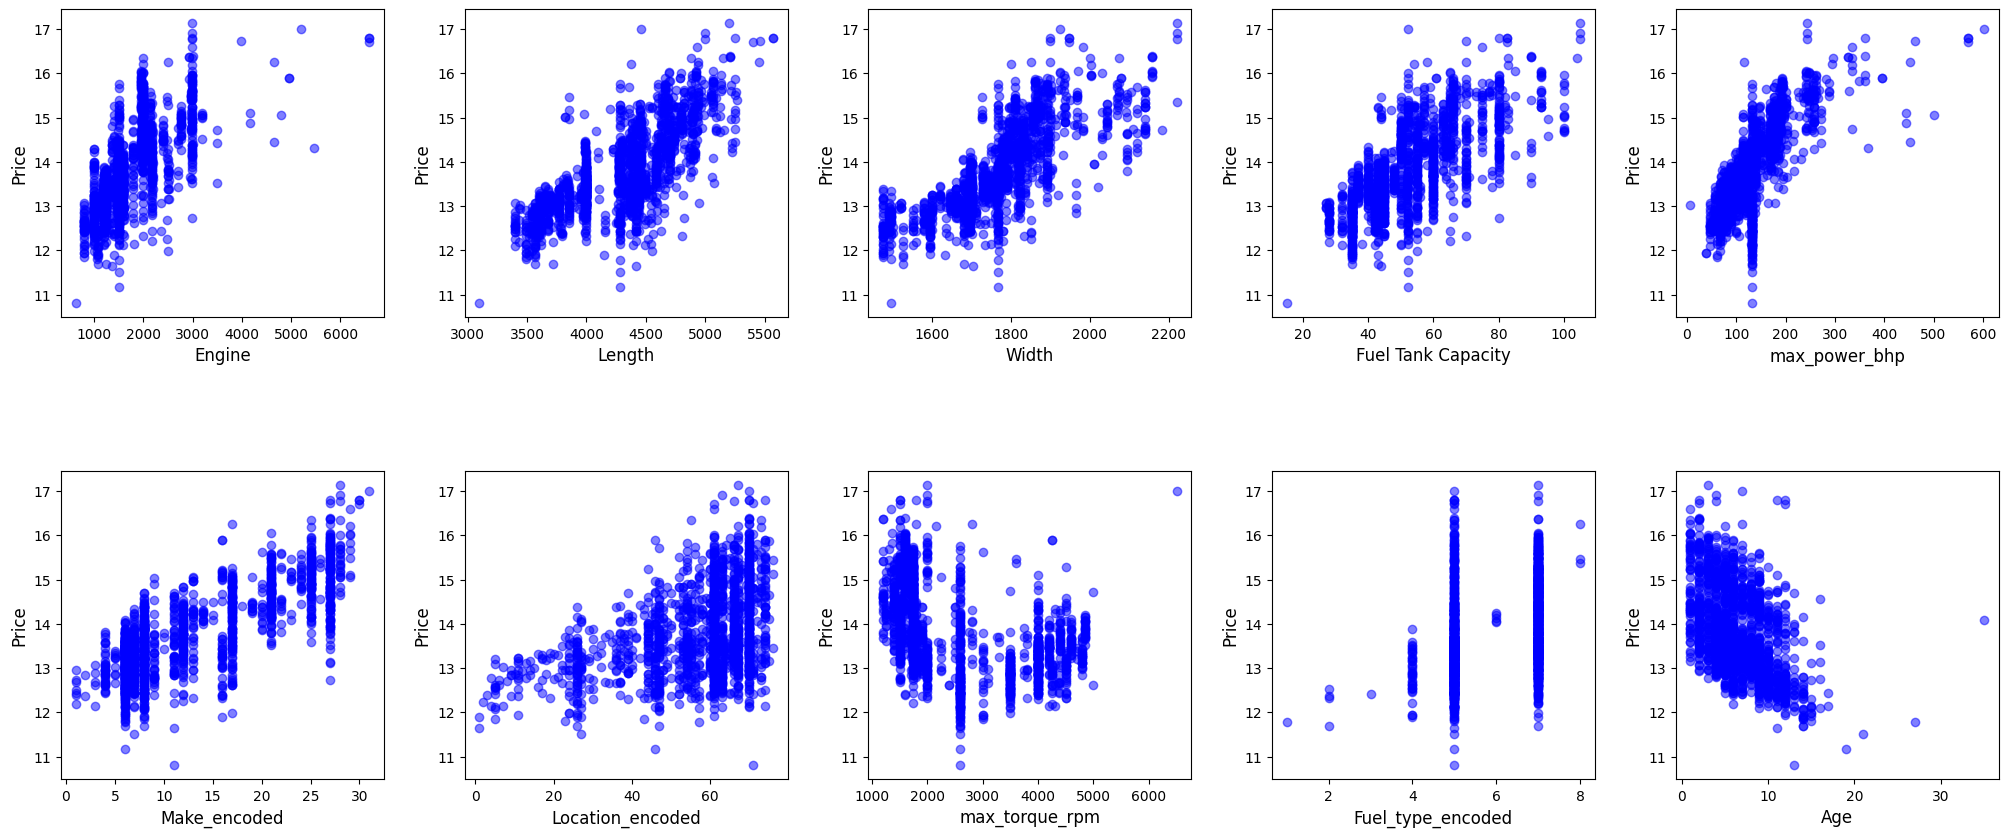

In [37]:
features = [
    "Engine",
    "Length",
    "Width",
    "Fuel Tank Capacity",
    "max_power_bhp",
    "Make_encoded",
    "Location_encoded",
    "max_torque_rpm",
    "Fuel_type_encoded",
    "Age",
    "Price"
]

plot_xy(df1[features], cols=5)

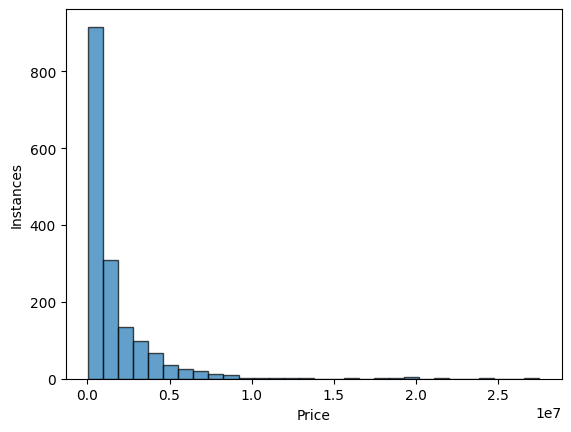

In [38]:
import matplotlib.pyplot as plt

column_name = "Price" 

plt.hist(df[column_name], bins=30, edgecolor="black", alpha=0.7)
plt.xlabel(column_name)
plt.ylabel("Instances")
plt.show()

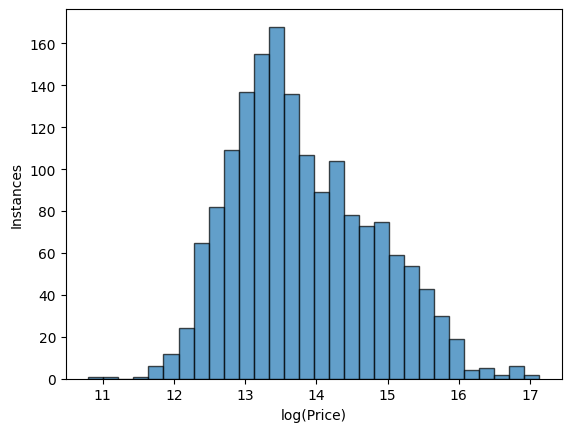

In [39]:
import matplotlib.pyplot as plt

column_name = "Price"  
plt.hist(np.log1p(df[column_name]), bins=30, edgecolor="black", alpha=0.7)
plt.xlabel("log(Price)")
plt.ylabel("Instances")
plt.show()